In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from biobank_olink.dataset import load_olink_and_covariates

ol_df, cov_df = load_olink_and_covariates(cols_na_th=0.3, rows_na_th=0.3, corr_th=0.9)
cov_df = cov_df.loc[cov_df.HTNgroup.isin((0, 1))]
ol_df = ol_df.loc[cov_df.index]
cov_df.head(5)

[Memory]0.0s, 0.0min    : Loading load_olink_and_covariates...


,sex,bmi,fastingtime,alcohol,smoking,age,sbp,dbp,pp,HTNgroup,unrelated,HTNcaseCoxfinal,timeHTNcoxfinal
eid,,,,,,,,,,,,,
1000366,1,23.7966,2.0,2.0,1.0,66,136.5,82.5,54.0,0,Yes,0,4823
1001182,0,26.7185,6.0,2.0,0.0,62,126.5,75.5,51.0,0,NaN,1,1349
1001297,0,23.5351,4.0,1.0,0.0,48,124.0,78.5,45.5,0,Yes,0,5655
1001306,0,35.6513,3.0,5.0,0.0,43,140.5,88.5,52.0,1,Yes,1,-5738
1001365,0,21.4709,5.0,3.0,2.0,62,141.5,82.5,59.0,1,Yes,0,4973


In [1]:
from biobank_olink.constants import Target
from biobank_olink.exp_two_extremes.data import get_data

x, y = get_data(target=Target.SBP, threshold=0.35, corr_th=0.9)
x.shape, y.shape

[Memory]0.0s, 0.0min    : Loading load_olink_and_covariates...


((9294, 2715), (9294, 1))

In [2]:
threshold = 0.35
target = "sbp"
lower_bound, upper_bound = cov_df[target].quantile([threshold, 1 - threshold]).values
low_cov_df = cov_df[cov_df[target] < lower_bound]
high_cov_df = cov_df[upper_bound < cov_df[target]]
pd.concat([low_cov_df[target].describe(), high_cov_df[target].describe()], axis=1,
          keys=["low", "high"])

,low,high
count,3330.000000,3425.000000
mean,140.969219,167.372993
std,4.085802,10.996677
min,117.000000,155.500000
25%,140.000000,159.000000
50%,142.000000,164.000000
75%,143.500000,173.000000
max,145.500000,246.000000


In [3]:
correction_df = pd.concat([low_cov_df, high_cov_df])
correction_cols = ["sex", "age", "bmi"]
correction_df = correction_df[correction_cols]
correction_df = (correction_df - correction_df.mean()) / correction_df.std()
correction_df.head()

,Sex,age,BMI
eid,,,
1001182,-0.835260,0.716531,0.009213
1001297,-0.835260,-0.989503,-0.708789
1001846,-0.835260,-0.745784,-1.622836
1002241,1.197174,-0.380205,1.458705
1002948,1.197174,-1.842520,-1.384592


In [4]:
from scipy.spatial.distance import pdist, squareform

similarities = squareform(pdist(correction_df))
np.fill_diagonal(similarities, np.inf)
similarities_df = pd.DataFrame(similarities, index=correction_df.index, columns=correction_df.index)
similarities_sub_df = similarities_df.loc[low_cov_df.index, high_cov_df.index]

paired_up_df = similarities_sub_df.idxmin().to_frame("p2_id")
paired_up_df["dist"] = similarities_df.min()
paired_up_df2 = similarities_sub_df.T.idxmin().to_frame("p2_id")
paired_up_df2["dist"] = similarities_df.T.min()
paired_up_df = pd.concat([paired_up_df, paired_up_df2])
paired_up_df.sort_values(by="dist", inplace=True)

del similarities_df, similarities
paired_up_df.head()

,p2_id,dist
eid,,
5161063,4730342,0.0
5199204,3382820,0.0
3191713,4083575,0.0
5813523,1999307,0.0
5199714,4051869,0.0


In [5]:
chosen = set()
for p1_idx, (p2_idx, _) in paired_up_df.iterrows():
    if p1_idx in chosen or p2_idx in chosen:
        continue
    chosen.add(p1_idx)
    chosen.add(p2_idx)

chosen_cov_df = cov_df.loc[list(chosen)]
low_cov_df = chosen_cov_df[chosen_cov_df[target] < lower_bound]
high_cov_df = chosen_cov_df[upper_bound < chosen_cov_df[target]]
pd.concat([low_cov_df[target].describe(), high_cov_df[target].describe()], axis=1,
          keys=["low", "high"])

,low,high
count,5018.000000,5018.000000
mean,119.005181,155.668394
std,6.832653,12.066937
min,76.500000,142.500000
25%,115.000000,146.500000
50%,120.500000,152.500000
75%,124.500000,161.000000
max,127.500000,246.000000


In [6]:
pd.concat([low_cov_df[correction_cols].describe(), high_cov_df[correction_cols].describe()], axis=1,
          keys=["low", "high"])

low                                   high               \
               Sex          age          BMI          Sex          age   
count  5018.000000  5018.000000  5018.000000  5018.000000  5018.000000   
mean      0.432443    56.765843    26.818846     0.432443    56.768035   
std       0.495464     7.623750     4.286982     0.495464     7.623307   
min       0.000000    40.000000    15.353500     0.000000    40.000000   
25%       0.000000    51.000000    23.893150     0.000000    51.000000   
50%       0.000000    58.000000    26.247150     0.000000    58.000000   
75%       1.000000    63.000000    29.053550     1.000000    63.000000   
max       1.000000    70.000000    55.134100     1.000000    70.000000   

                    
               BMI  
count  5018.000000  
mean     26.820585  
std       4.290746  
min      15.657300  
25%      23.880325  
50%      26.258500  
75%      29.053675  
max      56.263000

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=600, max_depth=3, learning_rate=0.1, random_state=42)
x = chosen_cov_df[correction_cols]
y = chosen_cov_df.index.isin(high_cov_df.index)

# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#auc score
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

## Best features correlation

In [337]:
from importlib.resources import files

DATA_DIR = files("biobank_olink.data")
ol_df_cp = ol_df.loc[chosen_cov_df.index]
ol_df_cp = (ol_df_cp - ol_df_cp.mean()) / ol_df_cp.std()

feat_imps_lr = pd.read_csv(
    DATA_DIR / "feat_importances" / "two_extremes_exp_sbp_th0.35_nan0.3_corr0.9_s42_lr.csv")
feat_imps_lr.sort_values("importance", ascending=False, inplace=True)
feat_imps_lr.set_index("feature", inplace=True)

feat_imps_xgb = pd.read_csv(
    DATA_DIR / "feat_importances" / "two_extremes_exp_sbp_th0.35_nan0.3_corr0.9_s42.csv")
feat_imps_xgb.sort_values("importance", ascending=False, inplace=True)
feat_imps_xgb.set_index("feature", inplace=True)

feat_imps = pd.concat([feat_imps_lr, feat_imps_xgb], axis=1, keys=["lr", "xgb"])
feat_imps[f"{target}_high - {target}_low"] = (
        ol_df_cp.loc[high_cov_df.index].mean() - ol_df_cp.loc[low_cov_df.index].mean()).abs()
feat_imps.sort_values(f"{target}_high - {target}_low", ascending=False, inplace=True)
feat_imps

,lr,xgb,SBP_high - SBP_low
,importance,importance,
feature,,,
REN,2.849398e-02,0.002224,0.450353
ERBB2,2.364902e-03,0.003179,0.341622
MEGF9,3.099450e-04,0.001622,0.299096
GGT1,1.467384e-03,0.002404,0.291793
CEACAM1,2.190216e-03,0.001963,0.291059
...,...,...,...
VAT1,1.556094e-03,0.000857,0.000079
SEMA4C,7.342628e-04,0.000819,0.000035


Text(0.5, 0.98, 'SBP')

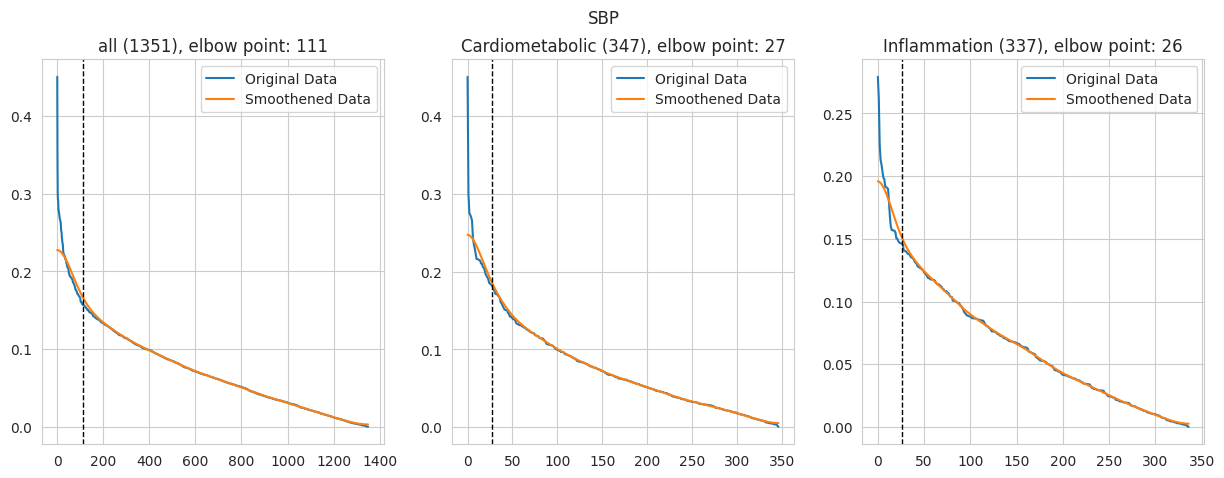

In [338]:
from scipy.ndimage import gaussian_filter
from biobank_olink.dataset import get_olink_panel_mapping
import matplotlib.pyplot as plt

panel_to_olinks = get_olink_panel_mapping()

col_name = f"{target}_high - {target}_low"
plt.figure(figsize=(15, 5))
selected_features = {}
for i, panel in enumerate(["all", "Cardiometabolic", "Inflammation"], 1):
    plt.subplot(1, 3, i)
    if panel == "all":
        olinks = ol_df.columns
    else:
        olinks = panel_to_olinks[panel]

    col = feat_imps[col_name][feat_imps.index.isin(olinks)].dropna().sort_values(ascending=False)
    y = col.values.reshape(-1)
    y_fit = gaussian_filter(y, 50 * len(y) / 1351)

    first_derivative = np.gradient(y_fit)
    second_derivative = np.gradient(first_derivative)
    curvature = second_derivative / np.power((1 + first_derivative ** 2), 3 / 2)
    elbow_point = np.argmax(curvature)

    selected_features[panel] = col.index[:elbow_point].values

    x = np.arange(len(y))
    plt.plot(x, y, label='Original Data')
    plt.plot(x, y_fit, label='Smoothened Data')
    plt.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    plt.title(f"{panel} ({len(col)}), elbow point: {elbow_point}")
    plt.legend()
plt.suptitle(target)

In [339]:
pd.concat([pd.Series(selected_feat) for selected_feat in selected_features.values()], axis=1,
          keys=selected_features.keys())

,all,Cardiometabolic,Inflammation
0,REN,REN,ERBB3
1,ERBB2,MEGF9,IL1R2
2,MEGF9,ACY1,TNFRSF11B
3,GGT1,NADK,DNER
4,CEACAM1,APOM,CLEC4A
...,...,...,...
106,ERBB4,NaN,NaN
107,DTX3,NaN,NaN
108,IL6ST,NaN,NaN
109,SETMAR,NaN,NaN


[(-0.0014246681865135312, 0.01)]

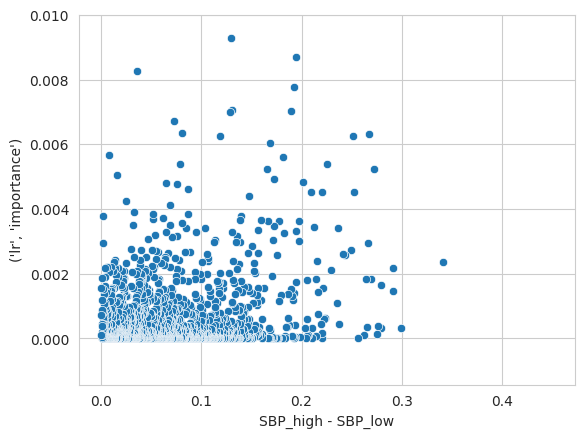

In [340]:
import seaborn as sns

ax = sns.scatterplot(data=feat_imps, x=col_name, y=("lr", "importance"))
ax.set(ylim=(None, 0.01))

In [341]:
feat_imps.corr()

,,lr,xgb,SBP_high - SBP_low
,,importance,importance,
lr,importance,1.000000,0.505053,0.277993
xgb,importance,0.505053,1.000000,0.498510
SBP_high - SBP_low,,0.277993,0.498510,1.000000
